# Noita 'Rickroll' QR Code Noise Analysis From Scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/probable-basilisk/noita_qr_analysis/blob/main/qr_noise_analysis.ipynb)


I have heard it said that nobody has been able to 'replicate' this analysis so here it is, in a conveniently
runnable colab notebook, totally from scratch starting with nothing more than the qrcode image from in game
and ending with both the binary and grayscale noise tables and the list of row offsets.

In [ ]:
# if you are running in colab, you'll need to run this cell to download the qrcode and moby dick
!wget -O qr.png https://github.com/probable-basilisk/noita_qr_analysis/blob/main/qr.png?raw=true
!wget -O mobydick.png https://github.com/probable-basilisk/noita_qr_analysis/blob/main/mobydick.png?raw=true
!wget -O hello_eye_room.png https://github.com/probable-basilisk/noita_qr_analysis/blob/main/hello_eye_room.png?raw=true

In [ ]:
# common imports
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import itertools
import operator
import collections
import json
plt.rcParams['figure.figsize'] = [10, 5]

## Part 0: Data Prep / Isolating the Noise

In [201]:
OUTDIR = "outputs/"

def omniwrite(fn, img):
  """
  Write any vaguely image-shaped array as an image.
  """
  img = np.copy(img.astype(np.uint8))
  if np.max(img) == 1:
    img *= 255
  if len(img.shape) < 3 or img.shape[2] == 1:
    img = np.dstack([img]*3)
  cv2.imwrite(OUTDIR + fn, img)


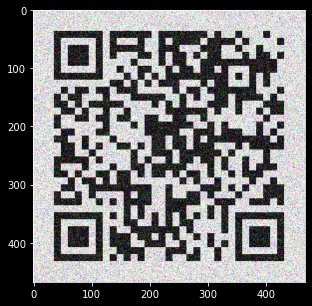

In [204]:
qrcode = cv2.imread("qr.png")
plt.imshow(qrcode)

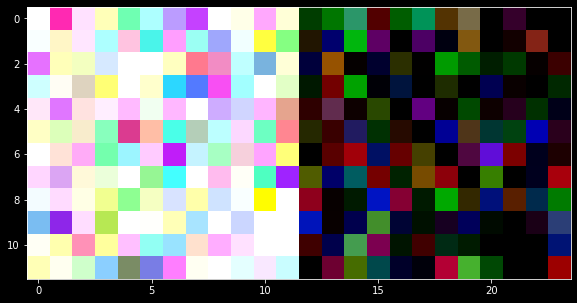

In [205]:
# First observations: the qrcode blocks are perfectly aligned to a 12x12 pixel grid
# This will simplify a lot of stuff
BLOCKSIZE = 12
IMAGEHEIGHT = qrcode.shape[0]
ROWSIZE = qrcode.shape[1]

def stack(img):
  """
  Stack the color channels of a [h,w,3] image into a [h*3,w] grayscale image
  """
  return np.vstack([img[:,:,c] for c in range(3)])

def destack(stacked):
  """
  Unstack a [h*3,w] grayscale image into a [h,w,3] color image
  """
  imageheight = stacked.shape[0] // 3
  return np.dstack([stacked[i*imageheight:(i+1)*imageheight] for i in range(3)])

def blockpos(row, col):
  return (row*BLOCKSIZE, col*BLOCKSIZE)

def extract_block(img, row, col, nrows=1, ncols=1):
  return img[row*BLOCKSIZE:(row+nrows)*BLOCKSIZE, col*BLOCKSIZE:(col+ncols)*BLOCKSIZE, :]

# Let's have a closer look at a white and black block
_ = plt.imshow(extract_block(qrcode, 5, 4, 1, 2))


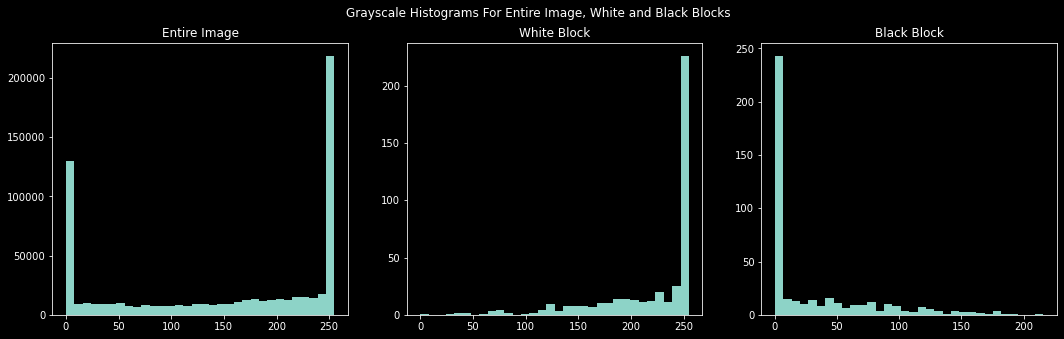

In [206]:
# Let's have a look at some histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Grayscale Histograms For Entire Image, White and Black Blocks')

ax1.set_title("Entire Image")
_ = ax1.hist(qrcode.reshape((-1)), bins=32)

ax2.set_title("White Block")
_ = ax2.hist(extract_block(qrcode, 5, 4).reshape((-1)), bins=32)

ax3.set_title("Black Block")
_ = ax3.hist(extract_block(qrcode, 5, 5).reshape((-1)), bins=32)


#### Observations:

* a white block has a large number of 255s
* a black block a large number of 0s
* the histograms of white and black blocks are mirrors of each other.

#### Conclusion:

The most elegant way of explaining this is that, because the underlying QR code is
purely (0,0,0) black and (255,255,255) white, that the noisy QR code is the result
of adding *signed* noise to the clean qr code: a black pixel 0 that has positive
noise added results in a positive value, while negative noise added to a black
pixel clamps to 0. Hence, for black blocks because half the signed noise is
negative, half the resulting pixels will remain exactly 0. Conversely, for white
blocks positive noise leaves the pixel pure white, while negative noise reduces
it to a value less than 255.

Therefore, for a 0 pixel in a black block, we cannot know the magnitude of the
noise, only that it was <= 0. Likewise, for a 255 pixel in a white block, we
only know the noise was >= 0.

We then isolate the noise from the qrcode, splitting it into three parts:
an image of signs, an image of magnitudes, and a validity mask. The
'validity' image indicates the pixels where we actually know the magnitude
of the noise: a 0 pixel in a black block is invalid because we can't recover
the magnitude of its noise (i.e., if it was a negative value, then it clamped
to zero).

331413 valid pixels


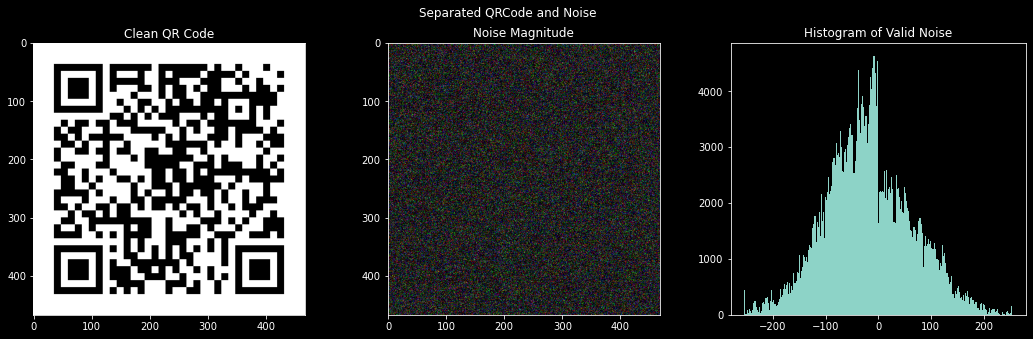

In [207]:
# Note that we will use the following convention for signs:
#  -1 -> 0 / False
#  +1 -> 1 / True
#
# The reason is that for much of our analysis it is faster/easier to work with
# binary arrays than with signed integer arrays.

def infer_block_color(block):
  """
  Determine whether a block of pixels was 0 or 255 prior to addition of noise.

  Returns (color, valids, signs, magnitudes)
  """
  is_white = (np.sum(block == 255) > np.sum(block == 0))
  if is_white:
    # Color: 1 (white)
    # Valid: if pixel < 255, valid
    # Sign: if pixel == 255, sign = 1 (positive)
    # Magnitude: difference from 255
    return (1, block < 255, block == 255, 255 - block)
  else:
    # Color: 0 (black)
    # Valid: if pixel > 0, valid
    # Sign: if pixel > 0, sign = 1 (positive)
    # Magnitude: difference from 0
    return (0, block > 0, block > 0, block - 0)

def isolate_noise_from_qrcode(img):
  base_color = np.zeros(img.shape[:2]).astype(int)

  noise_signs = np.zeros(img.shape)
  noise_mag = np.zeros(img.shape)
  noise_valid = np.zeros(img.shape)

  nrows = img.shape[0] // BLOCKSIZE
  ncols = img.shape[1] // BLOCKSIZE

  for row in range(nrows):
    for col in range(ncols):
      y, x = blockpos(row, col)
      (color, valids, signs, mags) = infer_block_color(extract_block(img, row, col))
      base_color[y:y+BLOCKSIZE, x:x+BLOCKSIZE] = color
      noise_valid[y:y+BLOCKSIZE, x:x+BLOCKSIZE, :] = valids
      noise_signs[y:y+BLOCKSIZE, x:x+BLOCKSIZE, :] = signs
      noise_mag[y:y+BLOCKSIZE, x:x+BLOCKSIZE, :] = mags

  return (base_color, noise_valid > 0, noise_signs > 0, noise_mag)

(qrcode_clean, isolated_noise_valid, isolated_noise_signs, isolated_noise_mag) = isolate_noise_from_qrcode(qrcode)
isolated_signed_noise = isolated_noise_mag * (2*isolated_noise_signs - 1)

qrcode_clean_color = np.dstack([qrcode_clean*255]*3).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Separated QRCode and Noise')
ax1.set_title('Clean QR Code')
ax1.imshow(qrcode_clean_color)
ax2.set_title('Noise Magnitude')
ax2.imshow(isolated_noise_mag.astype(np.uint8))
ax3.set_title('Histogram of Valid Noise')

temp = isolated_signed_noise.reshape((-1))
temp = temp[(isolated_noise_valid.reshape((-1)))]
print(len(temp), "valid pixels")

_ = ax3.hist(temp, bins=255)


The histogram of valid signed noise is lopsided because there are more white blocks (due to the margins around the qrcode) than black blocks,
so we are able to extract more negative noise values than positive ones. But, mentally taking that bias into account, it looks plausibly
normally distributed.

## Part 1: Extracting the Noise Table & Row Offsets

All the noise is actually drawn from a relatively small table of values: each row is simply a slice of a 4559 long array of signed noise.
Here we extract that table starting with nothing more than the assumption that every row of noise
comes out of some larger noise sequence.

For this part, we're going to ignore the noise magnitudes and focus only on matching rows using the noise signs, because the
signs are more robust than the magnitudes and because it is much more efficient to work with simple binary matching.

First, we're going to look for rows that have *exact overlaps* with other rows. To do this efficiently (i.e., without O(n^2) comparing
every row to every other row) we will build a hash table of every `MATCH_BITS` window of every row, and then check each row's
*tail* (the last `MATCH_BITS` of that row) against the hash table. Here I set `MATCH_BITS` to 32 so that the probability of accidentally
matching rows is so incredibly low that we can ignore the possibility.

In [208]:
# first, dealing with three color channels separately is annoying, so
# we're going to just stack the color channels into one 3x tall image

# consider the noise signs as instead a kind of 'binary noise'
binary_noise_stacked = stack(isolated_noise_signs)
magnitude_noise_stacked = stack(isolated_noise_mag)
valid_noise_stacked = stack(isolated_noise_valid)

# How many bits of exact match we need to link two rows.
# Note that 32 bits of exact match means the likelihood of
# a false positive, assuming uniform random binary noise, is about
# one in four billion. In other words, we would have to get
# extraordinarily unlucky to accidentally match two rows by chance.
MATCH_BITS = 32

# Convenience for easily turning a binary array into an integer
PLACE_VALUES = 2 ** np.arange(MATCH_BITS)

Now, we build up the hash table and then prune it to produce a directed graph of overlapping rows.

In [209]:
# Convert the last MATCH_BITS values of each row into an integer
# (just treat it as a binary number)
def calculate_row_tails(img):
  img = img.astype(int)
  return img[:, -MATCH_BITS:] @ PLACE_VALUES

# Create a dictionary that maps a *tail* (integer value)
# to the possible next rows that link to it
def create_possible_successors_map(noise):
  noise = noise.astype(int)
  successors = collections.defaultdict(set)
  # We iterate to width-1 because we do not want rows
  # to match with themselves: a successor needs to actually
  # *grow* the chain.
  for offset in range(noise.shape[1]-MATCH_BITS-1):
    windows = noise[:, offset:offset+MATCH_BITS]
    hashes = windows @ PLACE_VALUES
    for row, val in enumerate(hashes):
      successors[val].add((row, offset))
  return successors

# Count how many bits match between the tail of row_a
# and the candidate position pos in row_b
def count_alignment(row_a, row_b, pos):
  # =======|MATCH_BITS]        row_a
  #    [===|MATCH_BITS|======  row_b
  #        ^
  #        pos
  #    ~~~~~~~~~~~~~~~~ overlap
  overlap = pos + MATCH_BITS
  count = np.sum(row_a[-overlap:] == row_b[:overlap])
  return (count, overlap)

# Take the candidate successors and only keep the
# ones that actually exactly match in their overlaps
def prune_successors(candidates, rowidx, rows):
  successors = []
  for (candidx, pos) in candidates:
    (count, total) = count_alignment(rows[rowidx, :], rows[candidx, :], pos)
    if count == total:
      successors.append((candidx, pos, count))
  return successors

def create_successors(noise):
  succ = {}
  cand = create_possible_successors_map(noise)
  tails = calculate_row_tails(noise)
  for (rowidx, tail) in enumerate(tails):
    succ[rowidx] = prune_successors(cand[tail], rowidx, noise)
  return succ

succ = create_successors(binary_noise_stacked)


Next we search that graph to find the longest chain of overlapping rows.

In [210]:
# we do this with memoization/dynamic programming:
# we keep a dictionary ('longests') that keeps track of
# the longest chain rooted at a given row.
def _longest_rooted_chain(root, succ, longests):
  if root in longests:
    return longests[root]
  # break out with special sentinel value if we hit a cycle
  longests[root] = ((0, 0), -1)
  max_length = ROWSIZE
  max_succ = (-1, -1)
  for (idx, pos, count) in succ[root]:
    (_, sublength) = _longest_rooted_chain(idx, succ, longests)
    if sublength == -1: # cycle!
      return (None, -1)
    length = ROWSIZE + (sublength - (pos + MATCH_BITS))
    if length > max_length:
      max_length = length
      max_succ = (idx, pos)
  (idx, pos) = max_succ
  longests[root] = ((idx, pos), max_length)
  return longests[root]

# Then to find the globally longest chain, we just
# try every possible starting point.
def longest_chain(succ):
  longests = {}
  max_chain = -1
  max_idx = -1
  for rowidx in succ.keys():
    (_, length) = _longest_rooted_chain(rowidx, succ, longests)
    if length == -1: # cycle!
      return -1, []
    if length > max_chain:
      max_chain = length
      max_idx = rowidx
  chain = [(max_idx, 0)]
  curidx = max_idx
  offset = 0
  while True:
    ((nextidx, pos), _) = longests[curidx]
    if nextidx < 0:
      break
    curidx = nextidx
    offset += ROWSIZE - (pos + MATCH_BITS)
    chain.append((curidx, offset))
  return max_chain, chain

def assemble_chain(noise, chain):
  chain_length = max(offset + ROWSIZE for (_, offset) in chain)
  res = np.zeros(chain_length).astype(noise.dtype)
  for (rowidx, offset) in chain:
    res[offset:offset+ROWSIZE] = noise[rowidx, :]
  return res

chainsize, chain = longest_chain(succ)
print("Found a chain of size:", chainsize)
print("Chain:", chain)


Found a chain of size: 4559
Chain: [(320, 0), (183, 401), (1274, 834), (161, 1186), (686, 1561), (382, 1936), (42, 2187), (124, 2503), (1044, 2905), (1103, 3321), (1298, 3715), (185, 3921), (408, 4091)]


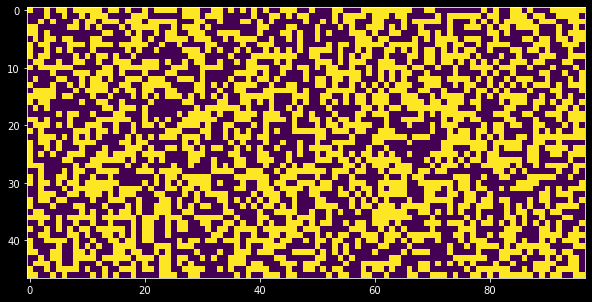

In [211]:
# Note that this is just a table of noise signs at the moment: we'll recover the
# magnitudes in a later step.
initial_noisetable_signs = assemble_chain(binary_noise_stacked, chain)

# if everything went correctly you should have gotten a noise table that's 4559 long,
# which is conveniently 47*97 so we can display it as rectangular image:
if chainsize == 4559:
  plt.imshow(initial_noisetable_signs.reshape((47, 97)))

#### Finding The Row Offsets

Now, we find each noise row's position in the noise table by just trying every position and picking
the one with the maximum similarity. 

Rows do not always have a perfect match in the noise table: they can differ by a few pixels. But we'll
find that on average each row will have a >99% match to some location in the noise table.

In [212]:
def find_row_offsets(noisetable, noise, normalize=True):
  offsets = []
  match_ratios = []
  # transform from [0, 1] -> [-1, 1]
  # (this is nicer for np.correlate)
  if normalize:
    table_normalized = noisetable.astype(float) * 2.0 - 1.0
    noise_normalized = noise.astype(float) * 2.0 - 1.0
  else:
    table_normalized = noisetable
    noise_normalized = noise
  rowsize = noise.shape[1]
  for (rowidx, row) in enumerate(noise):
    # we use np.correlate to find the position of maximum correlation
    # (this is vastly faster than for-looping ourselves)
    pos = np.argmax(np.correlate(
        table_normalized, noise_normalized[rowidx, :]))
    count = np.sum(row == noisetable[pos:pos+rowsize])
    offsets.append(pos)
    match_ratios.append(count / rowsize)
  return offsets, match_ratios

(row_offsets, match_ratios) = find_row_offsets(initial_noisetable_signs, binary_noise_stacked)
print("Mean match ratio:", np.mean(match_ratios))


Mean match ratio: 0.9920160956485743


#### Refining the Noise Table

The noise table we have already is pretty good, but since rows can differ by a few pixels we can try to
get a better noise table by using the offsets we just calculated to figure out the value in the noise
table that is *most consistent* with the rows that overlap it.

New mean match ratio: 0.9943659142377091


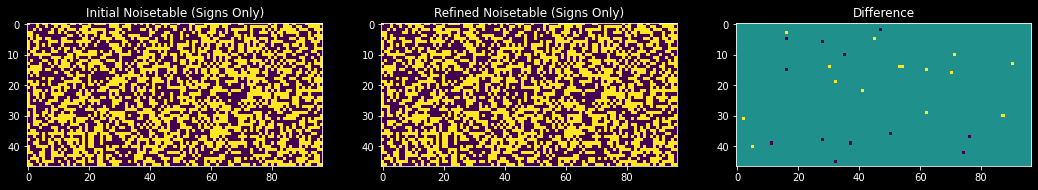

In [213]:
# Given a noise image and each row's offset into a noisetable (signs only),
# produce the noisetable that is *most consistent* with the image
def maximally_consistent_noisetable(offsets, noise):
  tablesize = np.max(offsets) + ROWSIZE

  # Place each row into the noise table and keep track of
  # how many 1s we see at each position, in addition to how many
  # rows 'see' that position in the table at all
  nones = np.zeros(tablesize)
  ncounts = np.zeros(tablesize)
  for row, offset in enumerate(offsets):
    nones[offset:offset+468] += noise[row, :]
    ncounts[offset:offset+468] += 1

  # the output noise table
  noisetable = np.zeros(tablesize)

  # set each noise table value to be the most common value
  # it has seen
  for idx in range(tablesize):
      none = nones[idx]
      ncount = ncounts[idx]
      if none > ncount / 2:
          noisetable[idx] = 1

  return noisetable

refined_noisetable_signs = maximally_consistent_noisetable(
    row_offsets, binary_noise_stacked)

(refined_row_offsets, match_ratios) = find_row_offsets(
    refined_noisetable_signs, binary_noise_stacked)
print("New mean match ratio:", np.mean(match_ratios))

if len(initial_noisetable_signs) == 4559:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
  ax1.set_title('Initial Noisetable (Signs Only)')
  ax1.imshow(initial_noisetable_signs.reshape((47, 97)))
  ax2.set_title('Refined Noisetable (Signs Only)')
  ax2.imshow(refined_noisetable_signs.reshape((47, 97)))
  ax3.set_title('Difference')
  diff = initial_noisetable_signs.astype(float) - refined_noisetable_signs.astype(float)
  ax3.imshow(diff.reshape((47, 97)))


Note that refining the noise table changed only a few dozen entries and very slightly improved the match ratio.

### Recovering the Noisetable Magnitudes

Now we need to recover the magnitude values of the noisetable in addition to the signs.

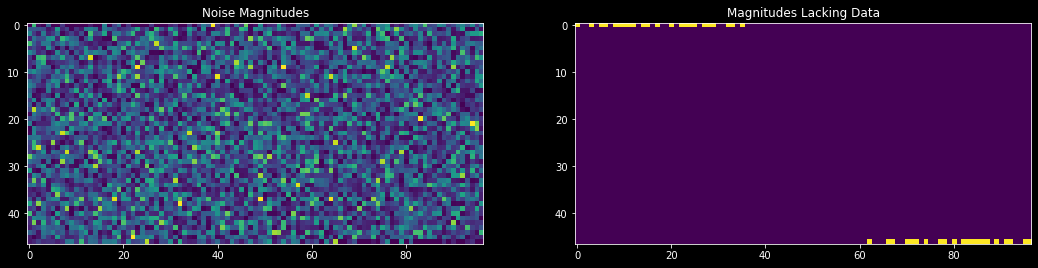

In [215]:
def accum_magnitudes(magnitudes, valids, offsets):
  maglists = collections.defaultdict(list)
  for rowidx, offset in enumerate(offsets):
    magrow = magnitudes[rowidx, :]
    validrow = valids[rowidx, :]
    for colidx in range(len(magrow)):
      if validrow[colidx] > 0:
        maglists[offset + colidx].append(magrow[colidx])
  return maglists

def visualize_maglists(maglists):
  most_mags = max(len(v) for v in maglists.values())
  max_idx = max(maglists.keys())
  ret = np.zeros((most_mags, max_idx+1))
  for idx, mags in maglists.items():
    sorted_mags = sorted(mags)
    ret[:len(sorted_mags), idx] = np.array(sorted_mags)
  return ret

def mode(amags):
  modals, counts = np.unique(amags, return_counts=True)
  return modals[np.argmax(counts)]

def collapse_mags(maglists, outsize, method=mode):
  max_idx = max(maglists.keys())
  finalmags = np.zeros((outsize))
  allzero = np.ones((outsize))
  for idx, mags in maglists.items():
    amags = np.array(mags)
    if len(amags) > 0:
      allzero[idx] = 0
      finalmags[idx] = method(amags)
  return (finalmags, allzero)

maglists = accum_magnitudes(magnitude_noise_stacked, valid_noise_stacked, refined_row_offsets)
(noise_magnitudes, allzero_magnitudes) = collapse_mags(maglists, len(refined_noisetable_signs), method=mode)

if len(noise_magnitudes) == 4559:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
  ax1.set_title('Noise Magnitudes')
  ax1.imshow(noise_magnitudes.reshape((47, 97)))
  ax2.set_title('Magnitudes Lacking Data')
  ax2.imshow(allzero_magnitudes.reshape((47, 97)))

# this visualizes the list of possible magnitudes for each entry in the noisetable
# (the image is 4559 wide so too large to really show inline in a notebook)
magvis = visualize_maglists(maglists)
omniwrite("magvis.png", magvis)


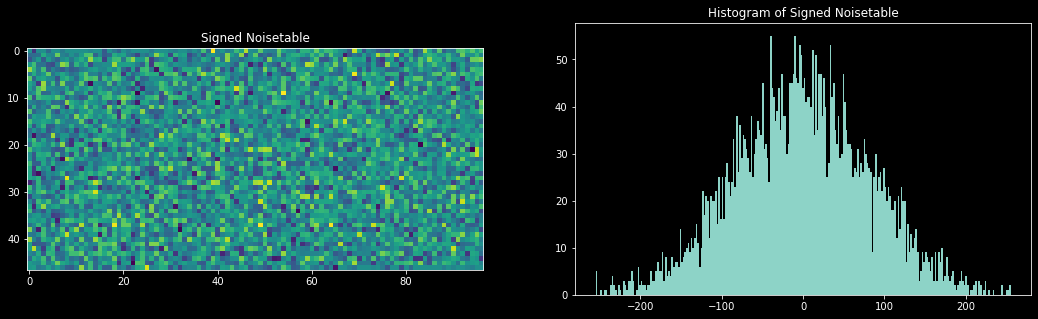

In [216]:
# Produce the 'final' signed noisetable
signed_noisetable = (refined_noisetable_signs * 2 - 1) * noise_magnitudes
if len(signed_noisetable) == 4559:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
  ax1.set_title('Signed Noisetable')
  ax1.imshow(signed_noisetable.reshape((47, 97)))
  ax2.set_title('Histogram of Signed Noisetable')
  _ = ax2.hist(signed_noisetable, bins=257)

#### Reconstructing the Noise

Now, we can reconstruct the noise, and see how well our reconstruction matches the original QR code.

Mean absolute difference (in 0-255 grayscale levels): 0.5776261962159398


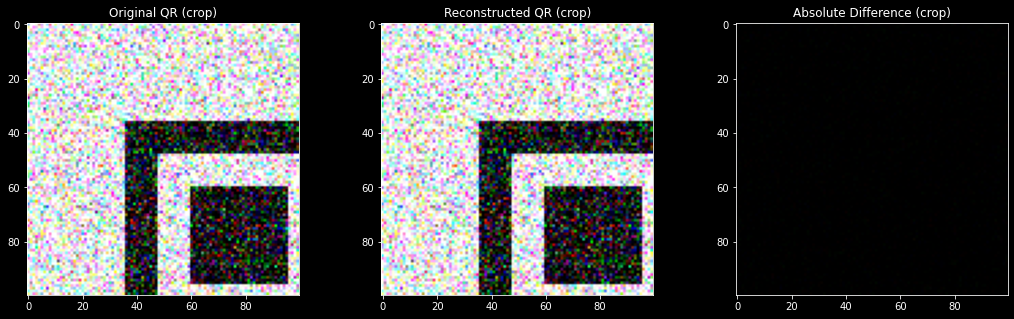

In [233]:
def reconstruct(noisetable, offsets):
  return np.vstack([noisetable[o:o+ROWSIZE] for o in offsets])

def add_u8_clamped(base, addition):
  ret = base.astype(float) + addition
  ret = np.maximum(0.0, np.minimum(255.0, ret))
  return ret.astype(np.uint8)

reconstructed_noise = destack(reconstruct(signed_noisetable, refined_row_offsets))
reconstructed_qr = add_u8_clamped(qrcode_clean_color, reconstructed_noise)
qr_diff = reconstructed_qr.astype(float) - qrcode.astype(float)
abs_qr_diff = np.abs(qr_diff)

print("Mean absolute difference (in 0-255 grayscale levels):", np.mean(np.abs(qr_diff)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.set_title('Original QR (crop)')
ax1.imshow(qrcode[0:100, 0:100, :])
ax2.set_title('Reconstructed QR (crop)')
ax2.imshow(reconstructed_qr[0:100, 0:100, :])
ax3.set_title('Absolute Difference (crop)')
ax3.imshow(abs_qr_diff[0:100, 0:100, :].astype(np.uint8))

# lets save out the difference in case we want to examine it in detail
# in an image editor
omniwrite("absolute_reconstruction_difference.png", abs_qr_diff.astype(np.uint8))
omniwrite("absolute_reconstruction_diff_stacked.png", stack(abs_qr_diff))

## Part 2: Cursory Observations of the Noise Table

So the 4559 signed noise table itself looks very similar to normally distributed random data.

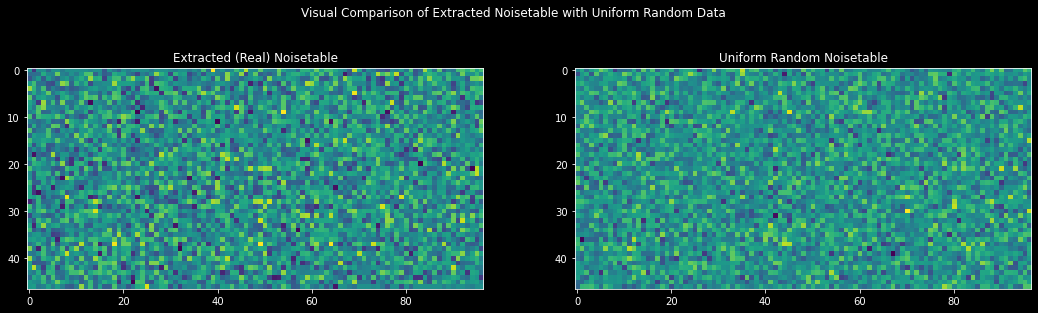

In [218]:
if len(signed_noisetable) == 4559:
  genuine_random_noisetable = np.random.normal(0.0, 40.0, signed_noisetable.shape)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
  fig.suptitle('Visual Comparison of Extracted Noisetable with Uniform Random Data')
  ax1.set_title('Extracted (Real) Noisetable')
  ax1.imshow(signed_noisetable.reshape((47, 97)))
  ax2.set_title('Uniform Random Noisetable')
  ax2.imshow(genuine_random_noisetable.reshape((47, 97)))

## Part 3: Initial Analysis of the Offsets

### Histograms and plots why not

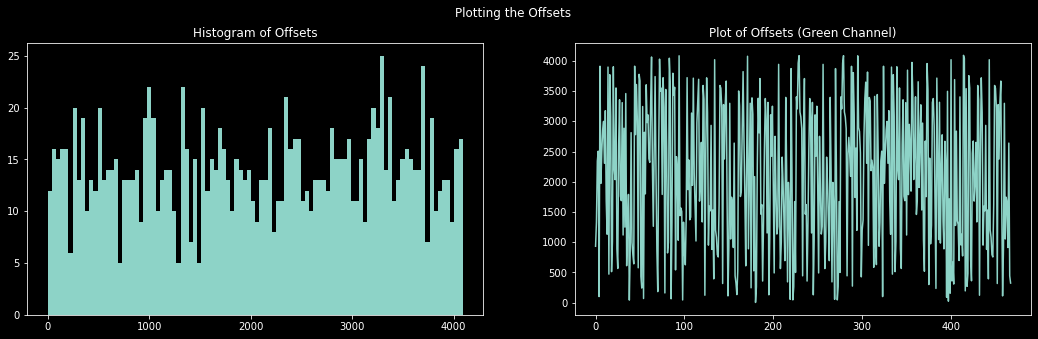

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Plotting the Offsets')
ax1.set_title('Histogram of Offsets')
ax1.hist(refined_row_offsets, bins=100)
ax2.set_title('Plot of Offsets (Green Channel)')
ax2.plot(refined_row_offsets[468:468+468])

Nothing obviously stands out.


### Finding Repeated Sequences

Since we know every row's location in the noise table, we can now semi-efficiently look
for repeated sequences of noise (because they will consist of a repeated sequence of row offsets).

For this part, we are going to find every repeat that is at least two rows large: note that since
there are 4559 - 468 = 4091 possible offsets, the expectation of seeing a repeat of length two
by chance is roughly on the order of (468*3)/(4091^2) ~= one in ten thousand. So if the offsets were
generated uniformly at random, we really wouldn't expect to see even a single small repeat.

In [220]:
def identical_run_length(seq, p0, p1):
  count = 0
  for a, b in zip(seq[p0:], seq[p1:]):
    if a != b:
      break
    count += 1
  return count

def find_repeated_offset_sequences(offsets):
  # first, build a map from offset -> row[]
  offset_positions = collections.defaultdict(list)
  for rowidx, offset in enumerate(offsets):
    offset_positions[offset].append(rowidx)

  runs = collections.defaultdict(int)
  runmatches = collections.defaultdict(list)

  for offset, positions in offset_positions.items():
    if len(positions) <= 1:
      # this offset only occurs once so can't repeat
      continue
    for row_a, row_b in itertools.combinations(positions, 2):
      runlen = identical_run_length(offsets, row_a, row_b)
      if runlen > 1:
        earlier_row = min(row_a, row_b)
        runs[earlier_row] = runlen
        runmatches[earlier_row].append(max(row_a, row_b))

  run_positions = sorted(runs.keys())
  for rowidx in run_positions:
    rl = runs[rowidx]
    if rl <= 1:
      continue
    for idx in range(1, rl+1):
      if runs[rowidx+idx] == rl-idx:
        runs[rowidx+idx] = 0

  ret = []
  for rowidx, run_length in runs.items():
    if run_length > 1:
      ret.append((run_length, rowidx, runmatches[rowidx][0]))
  return ret

def rowpos_to_imagepos(rowpos, channelnames=['B', 'G', 'R']):
  channel = channelnames[rowpos // IMAGEHEIGHT]
  ypos = rowpos % IMAGEHEIGHT
  return (channel, ypos)

def print_repeats(repeats, channelnames=['B', 'G', 'R']):
  for (repeat_length, row_a, row_b) in repeats:
    (ca, ya) = rowpos_to_imagepos(row_a, channelnames)
    (cb, yb) = rowpos_to_imagepos(row_b, channelnames)
    print(f"Repeat length {repeat_length} @ {ca}{ya}-{ya+repeat_length} matching {cb}{yb}-{yb+repeat_length}")

repeats = find_repeated_offset_sequences(refined_row_offsets)
print_repeats(repeats)

Repeat length 42 @ G117-159 matching G426-468
Repeat length 32 @ G0-32 matching G319-351
Repeat length 50 @ G184-234 matching G234-284
Repeat length 18 @ R0-18 matching R333-351
Repeat length 2 @ R117-119 matching R466-468
Repeat length 66 @ R168-234 matching R234-300


So, unlike the noisetable itself which doesn't have any obvious non-random characteristics, the
offsets into that noisetable have six repeats, five of which are so substantially large as to 
be effectively impossible by chance.

Visualizing the locations of the repeats as just solid colors:

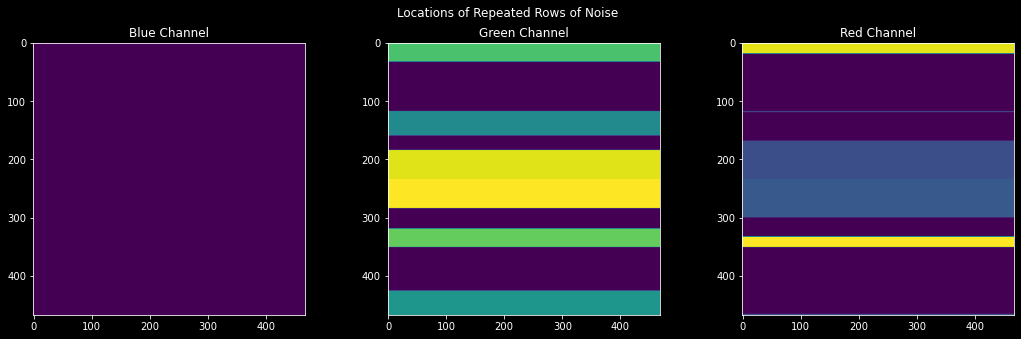

In [221]:
def vis_repeats(reps):
  # put more colors here if you need them
  COLORS = [100, 150, 200, 240, 50, 60, 70, 80] 

  dest = np.zeros((IMAGEHEIGHT*3, ROWSIZE), dtype=np.uint8)
  for color, (length, a, b) in zip(COLORS, reps):
    dest[a:a+length] = color
    dest[b:b+length] = color+10

  return dest

# This function isn't used at the moment
def crop_to_repeats(noise, offsets, repeats):
  out_img_parts = []
  out_offsets = []
  for (length, a, b) in repeats:
    out_offsets.extend(offsets[a:a+length])
    out_img_parts.append(noise[a:a+length,:])
  return (out_offsets, np.vstack(out_img_parts))

repeats_img = vis_repeats(repeats)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Locations of Repeated Rows of Noise')
ax1.set_title('Blue Channel')
ax1.imshow(repeats_img[:IMAGEHEIGHT,:])
ax2.set_title('Green Channel')
ax2.imshow(repeats_img[IMAGEHEIGHT:2*IMAGEHEIGHT,:])
ax3.set_title('Red Channel')
ax3.imshow(repeats_img[2*IMAGEHEIGHT:])

We can also search for not merely identical sequences (like 10, 30, 20 matching 10, 30, 20 elsewhere) but also 
sequences with additive shifts (e.g., 10, 30, 20 matching 15, 35, 25) by instead of directly searching the offsets,
searching the deltas or derivatives of the offsets (so 10, 30, 20 becomes 0, 20, -10).

In [222]:
offset_arr = np.array(refined_row_offsets)
offset_deltas = offset_arr[1:] - offset_arr[:-1]
repeat_deltas = find_repeated_offset_sequences(offset_deltas)
print_repeats(repeat_deltas)

Repeat length 31 @ G0-31 matching G319-350
Repeat length 41 @ G117-158 matching G426-467
Repeat length 49 @ G184-233 matching G234-283
Repeat length 17 @ R0-17 matching R333-350
Repeat length 65 @ R168-233 matching R234-299


This finds only the repeats we already knew about (except the length 2 repeat because taking the delta reduces lengths by one). 

Given the strange mirror symmetry, what about mirrored (reversed) sequences? To search for that we can concatenate the offsets with their
reverse:

In [223]:

offset_mirrored = np.hstack([offset_arr, np.flip(offset_arr)])
offset_mirrored_delta = offset_mirrored[1:] - offset_mirrored[:-1]
mirror_chans = ['B', 'G', 'R', '-R', '-G', '-B']

print("== Mirrored ==")
print_repeats(find_repeated_offset_sequences(offset_mirrored), mirror_chans)

print("== Mirrored Deltas ==")
print_repeats(find_repeated_offset_sequences(offset_mirrored_delta), mirror_chans)

== Mirrored ==
Repeat length 42 @ -G0-42 matching -G309-351
Repeat length 42 @ G117-159 matching G426-468
Repeat length 50 @ -G184-234 matching -G234-284
Repeat length 32 @ G0-32 matching G319-351
Repeat length 32 @ -G117-149 matching -G436-468
Repeat length 50 @ G184-234 matching G234-284
Repeat length 18 @ R0-18 matching R333-351
Repeat length 18 @ -R117-135 matching -R450-468
Repeat length 2 @ R117-119 matching R466-468
Repeat length 2 @ -R0-2 matching -R349-351
Repeat length 66 @ R168-234 matching R234-300
Repeat length 66 @ -R168-234 matching -R234-300
== Mirrored Deltas ==
Repeat length 49 @ -G184-233 matching -G234-283
Repeat length 17 @ -R117-134 matching -R450-467
Repeat length 31 @ G0-31 matching G319-350
Repeat length 41 @ G117-158 matching G426-467
Repeat length 49 @ G184-233 matching G234-283
Repeat length 17 @ R0-17 matching R333-350
Repeat length 65 @ R168-233 matching R234-299
Repeat length 65 @ -R168-233 matching -R234-299
Repeat length 41 @ -G0-41 matching -G309-350
R

Once again this just finds the same sequences we already knew about.

#### The stuff below until "observations" isn't worth looking at

min/max offset in repeat sections: 11 4085


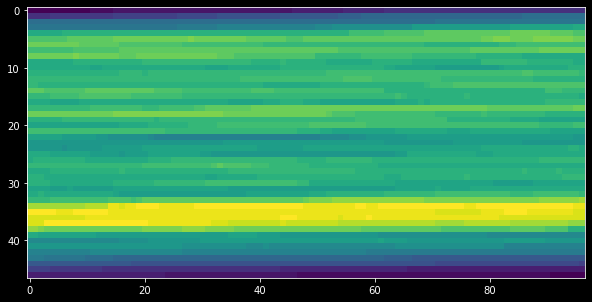

In [225]:
# This visualizes how many times each value in the noisetable is used

(hmm_offsets, hmm_noise) = crop_to_repeats(binary_noise_stacked, refined_row_offsets, repeats)
print("min/max offset in repeat sections:", np.min(hmm_offsets), np.max(hmm_offsets))
coverage_map = np.zeros(signed_noisetable.shape)
for offset in hmm_offsets:
  coverage_map[offset:offset+ROWSIZE] += 1
cmap = coverage_map.reshape((47,97))
plt.imshow(cmap)
#print(np.sum(coverage_map.reshape((47, 97)), axis=1))
omniwrite("coverage_map.png", 255.0*(cmap / np.max(cmap)))

[1358 3317]
[1358 3317]


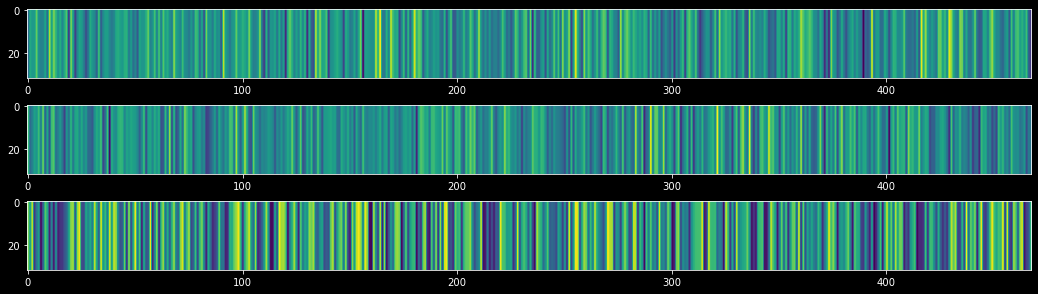

In [226]:
# This is looking at the 2 rows of repeated noise in the red channel
# (there is no obvious meaning to them)

print(offset_arr[ROWSIZE*2+117:ROWSIZE*2+119])
print(offset_arr[ROWSIZE*2+466:ROWSIZE*2+ROWSIZE])

def stretch(data, n=32):
  return np.repeat(data.reshape((1, -1)), n, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 5))
a = signed_noisetable[1358:1358+ROWSIZE]
b = signed_noisetable[3317:3317+ROWSIZE]
ax1.imshow(stretch(a))
ax2.imshow(stretch(b))
ax3.imshow(stretch(a.astype(np.uint8) ^ b.astype(np.uint8)))

In [190]:
# This is looking at the length 66 repeat in red, trying to see
# if I could identify any pattern by eye (no)

# Repeat length 66 @ R168-234 matching R234-300
r66_offsets = offset_arr[ROWSIZE*2+168:ROWSIZE*2+234]
r66_deltas = r66_offsets[1:] - r66_offsets[:-1]
print(r66_deltas)
M = 97
print(r66_offsets[:33] % M)
print(r66_offsets[33:] % M)
print((r66_offsets[33:] - r66_offsets[:33]) % M)
print((r66_offsets[33:] - np.flip(r66_offsets[:33])) % M)

def tobits(v, n=12):
  return [(v//(2**i))%2 for i in range(n)]

print(np.min(r66_offsets), np.max(r66_offsets))

print(tobits(3317))
print(tobits(1358))
print(np.array(tobits(3317)) ^ np.array(tobits(1358)))

#plt.scatter(r66_offsets[:33], np.flip(r66_offsets[33:]))

# tempo = (r66_offsets[33:] - r66_offsets[:33])

# tempimages = []
# for offsetoffset in range(4096 - 4041):
#   tempimages.append(np.vstack([np.array(tobits(o)) for o in (tempo + offsetoffset) % 1024]))
# plt.imshow(np.hstack(tempimages))
# omniwrite("offset_binary_shifts.png", np.hstack(tempimages))

[-1282  1906 -2225  -207  2389   346   849 -2054   502 -2103   281  1681
  1130  -676 -2427  -364  2182  -974   971  -341 -1694  3610 -3424  1008
  2284 -2946   710   428   510 -1247  1818  -332   928 -2043 -1276  1918
   551 -1204  2370 -3460  1258  1309 -2392  2014 -1217  1890 -2601  2635
  -731   789   -91 -3070  3323 -1881  -825  1678   869  -873   808  -309
  -221   607  -249  -964 -1050]
[34 13 76 82 69 33 88 64 47 64 95 85 20 83 86 84 11 59 55 56  6 58 79 50
 88 44  8 39 79  7 21 93 52]
[10  4 86 64 33 90 35 67 64 15 48 25 69 19 37 53  1 14 20 54 79 41 89 21
 17 17 49 31  4 29 71 77 94]
[73 88 10 79 61 57 44  3 17 48 50 37 49 33 48 66 87 52 62 95 73 80 10 68
 26 70 41 89 22 22 50 81 42]
[55  8 65 57 51 51 27 23 73 62 66 64 63 60 79 91 87 27 31 68 59 53 91 54
 67 50 58 95 32 44 92 64 60]
11 4041
[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
[1 1 0 1 1 1 0 1 1 0 0 1]


## Observations

* There are no repeats in the blue channel.
* The red and green channels each have three repeats.
* The repeats in both channels are arranged in an ABCCAB pattern.
* Every repeat has either its start or end aligned to an exact quarter of the image height (multiple of 117).
* Every repeat has an even length (6 repeats, so about a 1/64th chance).

The number and size of the repeats rule out coincidence, while the arrangement of the repeats 
seems to bear the hallmarks of deliberate placement for some purpose.

The alignment of the repeats has a kind of mirror symmetry around the vertical center of the image,
but it's not clear why. Does this suggest that some kind of folding operation needs to be done?

## Part 4: Against The Malfunctioning PRNG Hypothesis

Initially I suspected that the curious structure of the noise could be due to poor
PRNG choice or usage. For example, LCGs (linear congruential generators) are notorious for producing
low-period output in their least significant bits, so that a careless programmer who reduces the range
of a random number by modulo (e.g., `rand() % 2` to produce a binary value) can end up with random values
with very short periods.

At this point we can see some immediate problems in this hypothesis:

* The noise table has a strange size (4559) and more importantly isn't a cycle
* A bad LCG would produce low-period output everywhere rather than irregularly sized repeated patches
* There are no repeated sections in the blue channel: a bad PRNG shouldn't be selective like this
* A bad PRNG wouldn't align itself to 4ths of the image unless its period happened to be "just so"

Nevertheless, it would be really convenient if we could declare this mystery solved as the result of
bad programmers picking a perversely bad PRNG, so let's not let mere arguments stop us. Instead, let
us pick a perversely bad PRNG and see what the machinery we have build does to it.

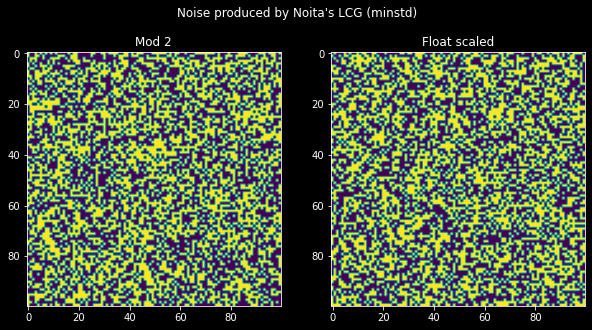

In [227]:
# This is the LCG that Noita likes to use (MINSTD, a version of
# https://en.wikipedia.org/wiki/Lehmer_random_number_generator )

LCG_A = 7**5
LCG_M = (2**31 - 1)
def noita_lcg_next(v):
  return (LCG_A * v) % LCG_M

LCG_SEED = 0xd00df00d

# generate an image from a prng next function and a seed
def prng_image(w, h, prng_next, seed):
  res = np.zeros((w*h), dtype=np.int64)
  prng_state = seed
  for pos in range(w*h):
    prng_state = prng_next(prng_state)
    res[pos] = prng_state
  return res.reshape((h,w))

noita_lcg_noise_raw = prng_image(468, 468*3, noita_lcg_next, LCG_SEED)

# do the bad thing and just %2 it to get binary noise
noita_lcg_noise_mod = noita_lcg_noise_raw % 2

# do a slightly less bad thing and convert it to floats
noita_lcg_noise_float = noita_lcg_noise_raw.astype(np.float64) / LCG_M
noita_lcg_binary_float = (noita_lcg_noise_float < 0.5).astype(float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Noise produced by Noita's LCG (minstd)")
ax1.set_title('Mod 2')
ax1.imshow(noita_lcg_noise_mod[:100,:100])
ax2.set_title('Float scaled')
ax2.imshow(noita_lcg_binary_float[:100,:100])

In [228]:
# now see if we can extract a noise chain of any sort
def test_noise(title, noise):
  print(title)
  succ = create_successors(noise)
  chainsize, chain = longest_chain(succ)
  if chainsize < 0:
    print("Cycle detected, but the logic to extract a cycle hasn't been written yet!")
    return
  print("Longest chain: ", chain)
  print("Chain length: ", chainsize)
  return chain

print("Note that it will always give you a chain of a single row (468)!\n")

# Run the real noise again just to convince ourselves our test actually works!
_ = test_noise("The actual QR code noise:", binary_noise_stacked)
print("")
_ = test_noise("Mod 2 MINSTD Noise:", noita_lcg_noise_mod)
print("")
_ = test_noise("Float-scaled MINSTD noise:", noita_lcg_binary_float)

Note that it will always give you a chain of a single row (468)!

The actual QR code noise:
Longest chain:  [(320, 0), (183, 401), (1274, 834), (161, 1186), (686, 1561), (382, 1936), (42, 2187), (124, 2503), (1044, 2905), (1103, 3321), (1298, 3715), (185, 3921), (408, 4091)]
Chain length:  4559

Mod 2 MINSTD Noise:
Longest chain:  [(0, 0)]
Chain length:  468

Float-scaled MINSTD noise:
Longest chain:  [(0, 0)]
Chain length:  468


Using the LCG that Noita actually uses in game did not result in any noise chains or cycles (note that the algorithm will always tell you
that there's a chain that's a single-row long, because every row can be considered a trivial chain by itself).

But, but... what if we make an even worse LCG.

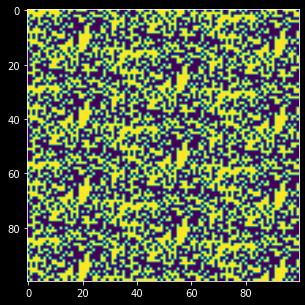

In [229]:
BAD_LCG_A = 83
BAD_LCG_M = (2**21 - 1) # try changing the exponent here
def incredibly_bad_lcg_next(v):
  return (BAD_LCG_A * v) % BAD_LCG_M

terrible_lcg_noise = prng_image(468, 468*3, incredibly_bad_lcg_next, 3) % 2
plt.imshow(terrible_lcg_noise[:100, :100])

In [230]:
_ = test_noise("Terrible noise:", terrible_lcg_noise)

Terrible noise:
Cycle detected, but the logic to extract a cycle hasn't been written yet!


#### Discussion

Yes, you can make a really bad LCG that repeats. But the repeats are both very regular (because "periodic" means "periodic") and very visible.

It's hard to prove a negative: _could_ there be some PRNG that exhibits the characteristics of the QRCode noise? I can't rule it
out. But the problem is that:

* Noita already uses MINSTD
* MINSTD can be implemented in one line
* MINSTD is already considered a bad PRNG
* Every common PRNG in use these days is better than MINSTD
* Yet even MINSTD doesn't create noise that can be compressed into a tiny noise table!

So I think the idea that the Nolla programmers went out of their way, just for the QR code, to engineer
a special PRNG that's stranger and worse than the MINSTD they already use, and instead of using any of the
better PRNGs common available, is quite implausible.

## Part 5: Creating Our Own Noise

A reasonable question to ask is, 'how complicated is it to make such noise'?
If intentionally creating noise like in the qrcode is very difficult, then that
might be evidence that it is an unintended artifact of some other process. So 
lets try to reproduce it.

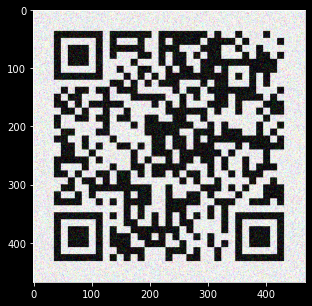

In [231]:
# Pick how large we want our tables to be
# We don't have to use 4559!
SYNTH_TABLE_SIZE = 7777

# Create a signed noisetable
synth_noise_table = np.random.normal(0.0, 50.0, size=(SYNTH_TABLE_SIZE))

# Create random offsets
# (note: the actual qrcode offsets have "weird stuff" going on but we don't understand that)
synth_offsets = np.random.randint(0, SYNTH_TABLE_SIZE-ROWSIZE, size=IMAGEHEIGHT*3)

# Construct the base grayscale noise from gray table & offsets
synth_noise = reconstruct(synth_noise_table, synth_offsets)

# Load in our 'secret' image and invert it into the noise
secret_image = (cv2.imread("hello_eye_room.png")[:,:,0] > 0).astype(np.uint8)
secret_image = np.vstack([secret_image]*3) # for three channels
synth_noise[secret_image > 0] *= -1.0

# add in visible QRCode and clamp and convert to uint8
synth_img = add_u8_clamped(qrcode_clean_color, destack(synth_noise))

synth_img = np.maximum(0.0, np.minimum(255.0, synth_img))
synth_img = synth_img.astype(np.uint8)

plt.imshow(synth_img)
omniwrite("fake_eyeroom_qr.png", synth_img)

Our own noise:
Longest chain:  [(148, 0), (1399, 402), (900, 802), (172, 1227), (892, 1570), (41, 1838), (1142, 2257), (628, 2668), (782, 3100), (208, 3523), (656, 3908), (289, 4291), (510, 4547), (1122, 4925), (520, 5265), (772, 5698), (1117, 6085), (726, 6448), (751, 6874), (248, 7307)]
Chain length:  7775
Mean match ratio: 0.752031740813792
New mean match ratio: 0.8185267367959677


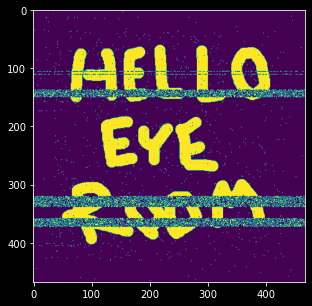

In [232]:
# Now lets try solving our own image
def solve_image(img):
  (_, __, signs, ___) = isolate_noise_from_qrcode(img)
  signs = stack(signs)
  resynth_chain = test_noise("Our own noise:", signs)
  initial_noisetable = assemble_chain(signs, resynth_chain)
  (row_offsets, match_ratios) = find_row_offsets(initial_noisetable, signs)
  print("Mean match ratio:", np.mean(match_ratios))

  refined_noisetable = maximally_consistent_noisetable(
      row_offsets, signs)

  (refined_row_offsets, match_ratios) = find_row_offsets(
      refined_noisetable, signs)
  print("New mean match ratio:", np.mean(match_ratios))

  reco = reconstruct(refined_noisetable, refined_row_offsets)
  diff = reco - signs
  return (reco, diff)

(reco_synth, diff_synth) = solve_image(synth_img)
plt.imshow(np.abs(diff_synth[468*1:468*2,:]))